In [4]:
%load_ext autoreload
%autoreload 2
from imports import *
from simcodes.helpers import *
%run simcodes/MultiBandSim.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
cluster.close()

In [5]:
cluster = SSHCluster(
                ["dodo1",'dodo2','dodo3','dodo4']+["dodo5",'dodo6'],
                connect_options={"known_hosts": None,"username": "ktisanic"},
                scheduler_options={"port": 0, "dashboard_address": ":46065"}
            )


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - /home/ktisanic/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 46065 is already in use.
distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
distributed.deploy.ssh - INFO - Hosting the HTTP server on port 37831 instead
distributed.deploy.ssh - INFO - warnings.warn(
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at: tcp://192.168.200.104:45859
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.200.105:39953'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.200.109:35531'
distributed

In [15]:

stars = pd.read_csv('data/query_1610017978.44685i.txt',skiprows=6,sep='\t')
stars['field']=stars['# ID'].str.split('-').apply(lambda x:x[1])
stars['Iband']=stars['# ID'].apply(lambda x:'data/ogle/I/'+x+'.dat')
stars['Vband']=stars['# ID'].apply(lambda x:'data/ogle/V/'+x+'.dat')

stars = pd.read_csv('data/query_1610017978.44685i.txt',skiprows=6,sep='\t')
stars['field']=stars['# ID'].str.split('-').apply(lambda x:x[1])
stars['Iband']=stars['# ID'].apply(lambda x:'data/ogle/I/'+x+'.dat')
stars['Vband']=stars['# ID'].apply(lambda x:'data/ogle/V/'+x+'.dat')
stars = stars[stars['field']=='BLG']

In [19]:

Analysis = pd.DataFrame()
Nreps = 8#
Percents = [7,10,15,70]

stats = ['mean','median','std','sem',p16,p84,med_sig,unexplained_variance,Outliers1,Outliers3]
Stats = ['mean','median','std','sem','p16','p84','med_sig','unexplained_variance', 'Outliers1','Outliers3']
Widths = np.round(np.logspace(-3,np.log10(0.4),10),3)
for w in Widths:
        try:
            os.mkdir(f'outputs/windows/w_{w}/')
        except:
            pass
for i in stars.index[:5]:
    for w in Widths:
        with open('Bootstrap_log.txt','w') as log:
                print(i, stars.loc[i,'# ID'],end='\t',file=log)
                print(i, stars.loc[i,'# ID'],end='\t')
                inds = []
                try:
                    Iband = pd.read_csv(stars.loc[i,'Iband'],names=['t','mag','magerr'],sep=' ')
                    Iband['filt'] = 'I'
                    inds.append(0)
                except:
                    print('No I',end='\t')
                    print('No I',end='\t',file=log)
                    Iband = None
                try:
                    Vband = pd.read_csv(stars.loc[i,'Vband'],names=['t','mag','magerr'],sep=' ')
                    Vband['filt']= 'V'
                    inds.append(1)
                except:
                    print('No V', end='\t')
                    print('No V', end='\t',file=log)
                    Vband=None
                if len(inds)==2:
                    D=pd.concat([Iband,Vband])
                elif len(inds)==1:
                    D = [Iband,Vband][inds[0]]
                else:
                    continue
                file = 'data/ogle/sources/'+stars.loc[i,'# ID']+'.dat'
                D.to_csv(file)
                N_I = (D['filt']=='I').count()
                N_V = (D['filt']=='V').count()
                Nmax = N_I+ N_V
                Sim = MCSimulation('data/ogle/sources/', stars.loc[i,'P_1'], file,verbose=False)
                Sim.compute_phase()

                #sims=np.unique(np.round(Nmax*Percents).astype(int))


                Dict = {'Name':stars.loc[i,'# ID'],'OGLE period':stars.loc[i,'P_1'],#'LS period':Sim.best_fitting[1],
                        'N_I':N_I,'N_V':N_V}
                #for Per in Percents:
                ok = False


                for _ in range(3):
                        Sim.produce_bootstrap(Percents,Nreps)
                        Sim.remove_window(0.5,w)
                        print(f"Bootstrap {_}",f"window {w}", end='\t',file=log)
                        print(f"Bootstrap {_}",f"window {w}", end='\t')
                        #Sim.produce_bootstrap([Per],Nreps)
                        try:
                            Sim.run_simulation('fast',cluster=cluster)
                            ok = True
                        except:
                            print(Percents,'Fail',end='\t')
                            print(Percents,'Fail',end='\t',file=log)
                        if ok:
                            Stat = Sim.Simulated_periods.groupby('N').agg({'P':stats})
                            for ind in Stat.index:
                                for st in Stats:
                                    Dict[f'{ind} '+st] = Stat.loc[ind,('P',st)]
                                    Dict['window'] = w
                            break
                print(ok)
                print(ok,file=log)
                Analysis = Analysis.append(Dict, ignore_index=True)
                Analysis.to_csv('Manystars.csv')
#cluster.close()

27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.001	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.002	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.004	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.007	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.014	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.028	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.054	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.106	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.206	D	True
27381 OGLE-BLG-RRLYR-00001	Bootstrap 0 window 0.4	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.001	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.002	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.004	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.007	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.014	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.028	D	True
27382 OGLE-BLG-RRLYR-00002	Bootstrap 0 window 0.054	D	True

In [20]:
Analysis

,10 Outliers1,10 Outliers3,10 mean,10 med_sig,10 median,10 p16,10 p84,10 sem,10 std,10 unexplained_variance,...,70 p16,70 p84,70 sem,70 std,70 unexplained_variance,N_I,N_V,Name,OGLE period,window
0,0.250,0.125,0.378788,0.216896,0.110835,0.102354,0.679044,0.175185,0.495499,0.239584,...,0.732543,0.732557,4.892394e-06,0.000014,6.621003e-11,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.001
1,0.250,0.000,0.314816,0.273798,0.166971,0.109949,0.692220,0.097393,0.275468,0.013290,...,0.119581,0.732529,1.110288e-01,0.314037,-4.612454e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.002
2,0.375,0.000,0.366566,0.458020,0.135618,0.104339,0.734488,0.121804,0.344514,-0.052592,...,0.114793,0.732554,1.143879e-01,0.323538,-1.115980e-01,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.004
3,0.250,0.250,0.362443,0.137673,0.118542,0.101333,0.661359,0.177778,0.502832,0.261769,...,0.188584,0.732556,1.012399e-01,0.286350,8.252430e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.007
4,0.250,0.250,0.230757,0.074194,0.115507,0.105561,0.404535,0.082582,0.233578,0.055517,...,0.732507,0.732565,7.069323e-02,0.199951,3.997950e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.014
5,0.250,0.125,2.733479,2.882491,0.857074,0.110071,6.427324,1.315743,3.721482,7.330391,...,0.732470,0.732541,7.720317e-02,0.218364,4.768299e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.028
6,0.250,0.250,1.487468,1.017355,0.141703,0.103068,4.836445,0.892134,2.523335,6.347390,...,0.215068,0.732556,9.673151e-02,0.273598,7.544932e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.054
7,0.250,0.250,0.229533,0.025331,0.117996,0.108102,0.189270,0.103649,0.293164,0.087001,...,0.109440,0.732561,1.102657e-01,0.311879,-7.267693e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.106
8,0.250,0.250,1.432815,0.168478,0.128207,0.113250,0.879012,1.193201,3.374881,11.639712,...,0.136821,8.581571,1.538193e+00,4.350666,1.653201e+01,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.206
9,0.250,0.250,2.528340,1.774105,0.117388,0.107243,8.421572,1.578590,4.464928,20.108876,...,0.102572,0.662199,1.013088e-01,0.286545,7.597601e-02,106.0,106.0,OGLE-BLG-RRLYR-00001,0.732588,0.400


No handles with labels found to put in legend.
<ipython-input-49-d89c5d937f1c>:32: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


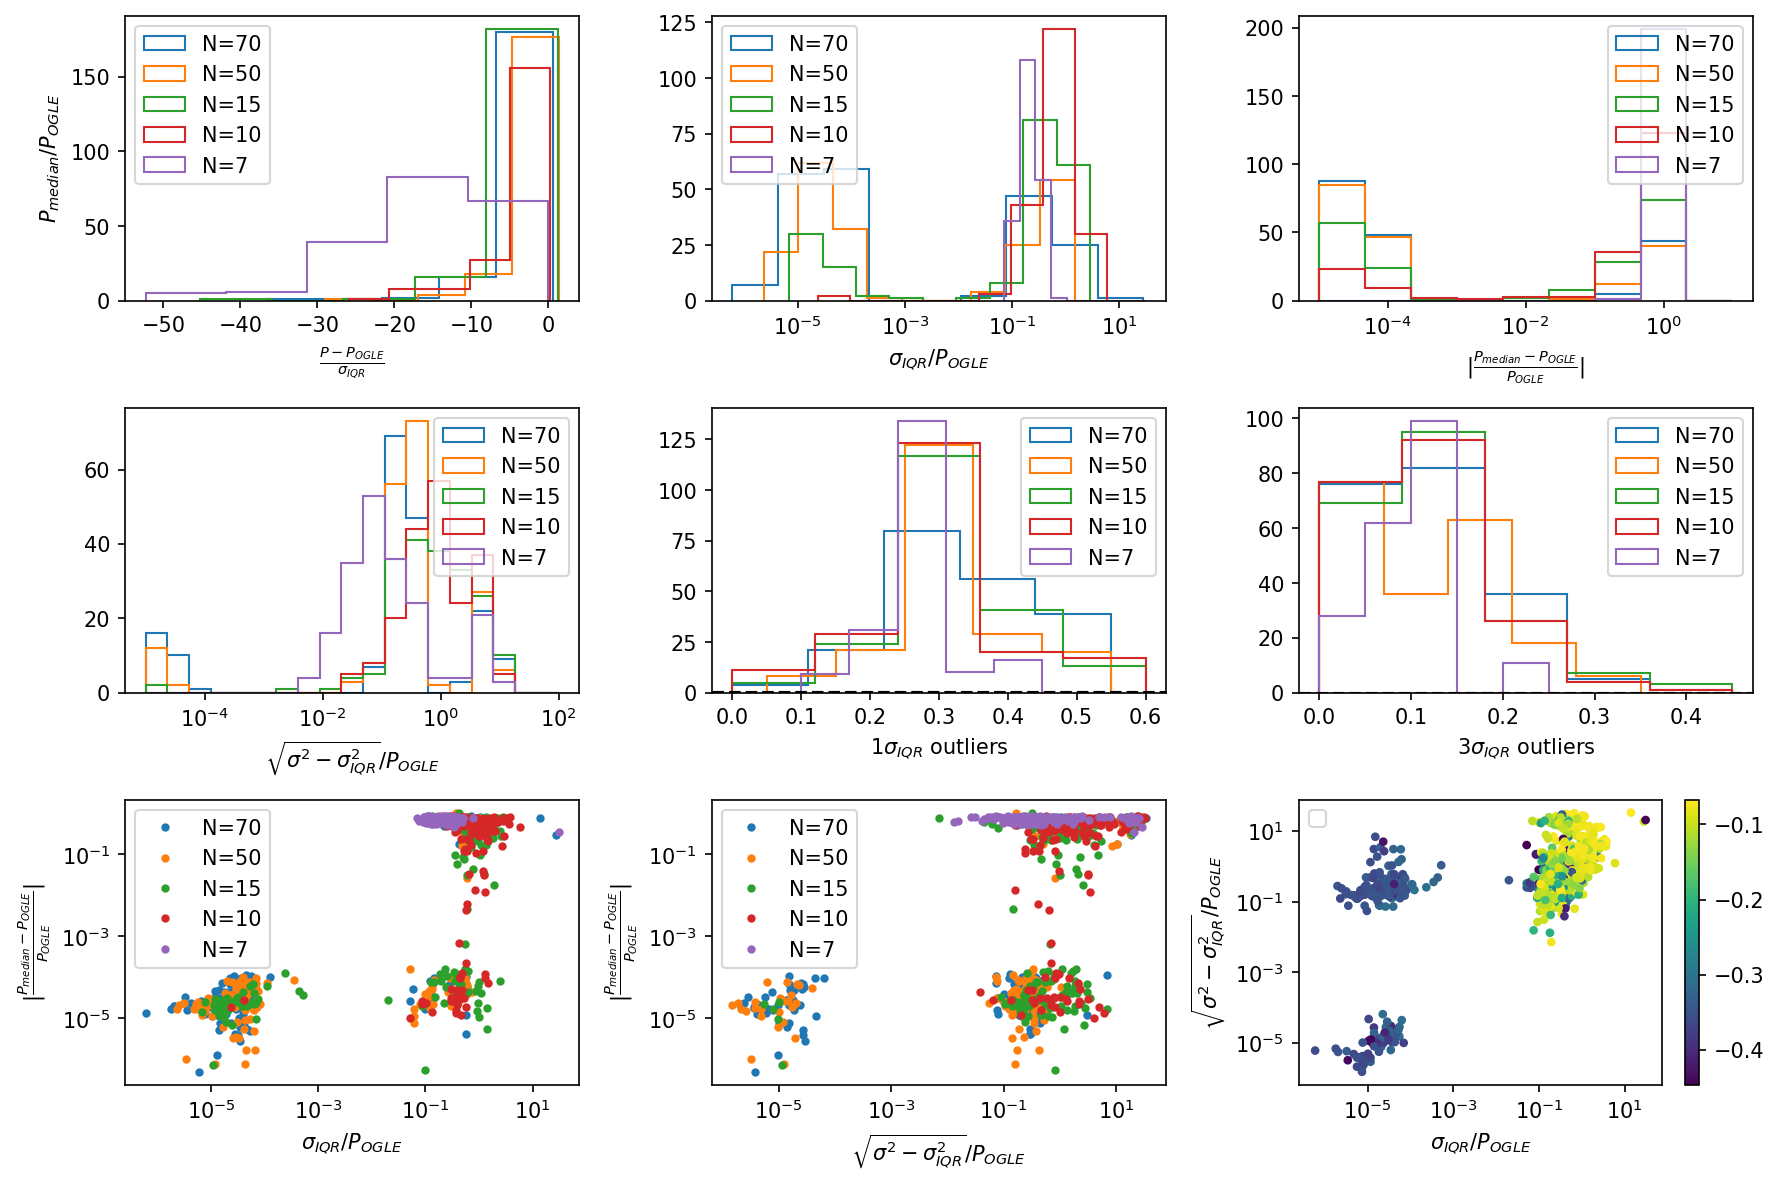

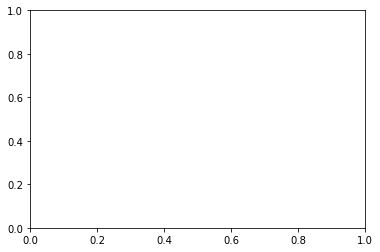

In [49]:
Percents = [7,10,15,50,70]
fig, ax = plt.subplots(ncols=3, nrows=3, constrained_layout=True,figsize=(12,8),
                             gridspec_kw=dict(width_ratios=[1,1,1], height_ratios=[1,1,1]),dpi=150)
fig2, ax2 = plt.subplots(1,1)
ax = ax.flatten()
for s in Percents[::-1]:
    ax[0].hist((Analysis[f'{s} median']-Analysis['OGLE period'])/Analysis[f'{s} med_sig'],5,label=f'N={s}',histtype='step',)
    K = Analysis[f'{s} med_sig']/Analysis[f'{s} median']
    ax[1].hist(K,np.logspace(np.log10(K.min()),np.log10(K.max()),10),label=f'N={s}',histtype='step')
    ax[6].plot(Analysis[f'{s} med_sig']/Analysis[f'{s} median'],abs(Analysis[f'{s} median']-Analysis['OGLE period'])/Analysis['OGLE period'],'.',label=f'N={s}',)
    ax[7].plot(np.sqrt(np.abs(Analysis[f'{s} unexplained_variance']/Analysis[f'{s} median']**2)),abs(Analysis[f'{s} median']-Analysis['OGLE period'])/Analysis['OGLE period'],'.',label=f'N={s}',)
    im=ax[8].scatter(Analysis[f'{s} med_sig']/Analysis[f'{s} median'],
                     np.sqrt(np.abs(Analysis[f'{s} unexplained_variance']/Analysis[f'{s} median']**2)),
                     c=np.log10(abs(Analysis[f'{s} median']-Analysis['OGLE period'])/Analysis['OGLE period']),s=10)
    
    ax[2].hist(abs(Analysis[f'{s} median']-Analysis['OGLE period'])/Analysis['OGLE period'],np.logspace(-5,1,10),histtype='step',label=f'N={s}')
    ax[3].hist(np.sqrt(np.abs(Analysis[f'{s} unexplained_variance']/Analysis['OGLE period']**2)),np.logspace(-5,2,20),histtype='step',label=f'N={s}')
    ax[4].hist(Analysis[f'{s} Outliers1'],5,label=f'N={s}',histtype='step')
    ax[5].hist(Analysis[f'{s} Outliers3'],5,label=f'N={s}',histtype='step')

for _, _x, _y, _xs, _ys in zip(ax,
                               [r'$\frac{P-P_{OGLE}}{\sigma_{IQR}}$',r'$\sigma_{IQR}/P_{OGLE}$',r'$\left|\frac{P_{median}-P_{OGLE}}{P_{OGLE}}\right|$',r'$\sqrt{\sigma^2-\sigma^2_{IQR}}/P_{OGLE}$']+[r'$1\sigma_{IQR}$ outliers', r'$3\sigma_{IQR}$ outliers',r'$\sigma_{IQR}/P_{OGLE}$',r'$\sqrt{\sigma^2-\sigma^2_{IQR}}/P_{OGLE}$',r'$\sigma_{IQR}/P_{OGLE}$'],
                     [r'$P_{median}/P_{OGLE}$',"","","", "","",r'$\left|\frac{P_{median}-P_{OGLE}}{P_{OGLE}}\right|$',r'$\left|\frac{P_{median}-P_{OGLE}}{P_{OGLE}}\right|$',r'$\sqrt{\sigma^2-\sigma^2_{IQR}}/P_{OGLE}$'], ['linear','log']+2*['log']+2*['linear']+['log','log','log'],['linear','linear']+4*['linear']+['log','log','log']):
    _.set_xlabel(_x)
    _.set_ylabel(_y)
    _.legend()
    _.set_xscale(_xs)
    _.set_yscale(_ys)
ax[4].axhline(1-0.6827,color='k',ls='dashed')
ax[5].axhline(1-0.9973,color='k',ls='dashed')
plt.colorbar(im,ax=ax[8])
fig.tight_layout()

In [ ]:
# windowing, podjela po tipu. # jitter